In [24]:
import sys
sys.path.append("C:\\Users\\Sheng\\epstein_network_civil_violence")
print(sys.path)

['C:\\Users\\Sheng', 'D:\\python\\python311.zip', 'D:\\python\\DLLs', 'D:\\python\\Lib', 'D:\\python', '', 'D:\\python\\Lib\\site-packages', 'D:\\python\\Lib\\site-packages\\win32', 'D:\\python\\Lib\\site-packages\\win32\\lib', 'D:\\python\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\Sheng\\epstein_network_civil_violence', 'C:\\Users\\Sheng\\epstein_network_civil_violence', 'C:\\Users\\Sheng\\epstein_network_civil_violence', 'C:\\Users\\Sheng\\epstein_network_civil_violence', 'C:\\Users\\Sheng\\epstein_network_civil_violence', 'C:\\Users\\Sheng\\epstein_network_civil_violence', 'C:\\Users\\Sheng\\epstein_network_civil_violence', 'C:\\Users\\Sheng\\epstein_network_civil_violence']


In [25]:
import math

from epstein_civil_violence.agent import Citizen, Cop


class Inhabitant(Citizen):

    def __init__(
            self,
            unique_id,
            model,
            pos,
            hardship,
            regime_legitimacy,
            risk_aversion,
            threshold,
            vision,
            alpha,
            jail_factor,
            impact_chance,
            legitimacy_impact,
            incitation_threshold,
    ):
        """
        Create a new Inhabitant.
        Args:
            unique_id: unique int
            x, y: Grid coordinates
            hardship: Agent's 'perceived hardship (i.e., physical or economic
                privation).' Exogenous, drawn from U(0,1).
            regime_legitimacy: Agent's perception of regime legitimacy, equal
                across agents.  Exogenous.
            risk_aversion: Exogenous, drawn from U(0,1).
            threshold: if (grievance - (risk_aversion * arrest_probability)) >
                threshold, go/remain Active
            vision: number of cells in each direction (N, S, E and W) that
                agent can inspect. Exogenous.
            model: model instance
            alpha: Deterrent effect.
            jail_factor: grievance modifier that agents leave jail.
            legitimacy_impact: strength of legitimacy impact by incitation.
        """

        super().__init__(
            unique_id,
            model,
            pos,
            hardship,
            regime_legitimacy,
            risk_aversion,
            threshold,
            vision)
        self.breed = "citizen"
        self.condition = "Quiescent"
        self.jail_sentence = 0
        self.grievance = self.hardship * (1 - self.regime_legitimacy)
        self.arrest_probability = None
        self.alpha = alpha
        self.jail_factor = jail_factor
        self.impact_chance = impact_chance
        self.legitimacy_impact = legitimacy_impact
        self.incitation_num = 0
        self.incitation_threshold = incitation_threshold
        self.cops_in_vision = 0
        self.actives_in_vision = 0

    def update_estimated_arrest_probability(self):
        """
        Based on the ratio of cops to actives in my neighborhood, estimate the
        p(Arrest | I go active).
        """
        cops_in_vision = len([c for c in self.neighbors if c.breed == "cop"])
        actives_in_vision = 1.0  # citizen counts herself
        for c in self.neighbors:
            if (
                    c.breed == "citizen"
                    and c.condition == "Active"
                    and c.jail_sentence == 0
            ):
                actives_in_vision += 1
        self.arrest_probability = 1 - math.exp(
            -1 * self.model.arrest_prob_constant * (cops_in_vision / actives_in_vision)
        )
        self.cops_in_vision = cops_in_vision
        self.actives_in_vision = actives_in_vision

    def step(self):
        """
        Decide whether to activate, then move if applicable.
        """
        if self.jail_sentence:
            self.jail_sentence -= 1
            if self.jail_sentence == 0:
                self.update_grievance_leave_jail()
            return  # no other changes or movements if agent is in jail.
        self.update_neighbors()
        self.update_estimated_arrest_probability()


        net_risk = self.risk_aversion * self.arrest_probability * self.random.randint(0,
                                                                                      self.model.max_jail_term) ** self.alpha - 0.3

        if self.condition == "Quiescent":
            if self.grievance - net_risk > self.threshold and self.actives_in_vision >= (2 * self.cops_in_vision):
                self.condition = "Active"
                self.incite_grievance()
            else:
                self.condition = "Quiescent"
        else:
            if self.grievance - net_risk < self.threshold or self.cops_in_vision >= 1:
                self.condition = "Quiescent"

        # making arrest if incitation number greater than threshold
        if self.incitation_num > self.incitation_threshold:
            sentence = self.random.randint(0, self.model.max_jail_term)
            self.jail_sentence = sentence
            self.condition = "Quiescent"
            self.incitation_num = 0
        if self.model.movement and self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            self.model.grid.move_agent(self, new_pos)

    def update_grievance_leave_jail(self):
        # print('grievance_before_jail: ' + str(self.grievance))
        self.grievance *= self.jail_factor
        # print('update_grievance_leave_jail: ' + str(self.grievance))

    def incite_grievance(self):
        quiescent_neighbors = []
        for agent in self.neighbors:
            if agent.breed == "citizen" and agent.condition == "Quiescent":
                quiescent_neighbors.append(agent)
        if quiescent_neighbors and self.random.randrange(0, 1.0) < self.impact_chance:
            influencee = self.random.choice(quiescent_neighbors)
            if influencee.regime_legitimacy > 0.2:  # minium regime legitimacy cannot be under 0.2
                influencee.regime_legitimacy -= self.legitimacy_impact
                self.incitation_num += 1
                # print('incite_grievance')


class Police(Cop):

    def __init__(self, unique_id, model, pos, vision):
        """
        Create a new Cop.
        Args:
            unique_id: unique int
            x, y: Grid coordinates
            vision: number of cells in each direction (N, S, E and W) that
                agent can inspect. Exogenous.
            model: model instance
        """
        super().__init__(unique_id, model, pos, vision)
        self.breed = "cop"
        # self.pos = pos
        # self.vision = vision

    def step(self):
        """
        Inspect local vision and arrest a random active agent. Move if
        applicable.
        """
        self.update_neighbors()
        active_neighbors = []
        for agent in self.neighbors:
            if (
                    agent.breed == "citizen"
                    and agent.condition == "Active"
                    and agent.jail_sentence == 0
            ):
                active_neighbors.append(agent)
        if active_neighbors:
            arrestee = self.random.choice(active_neighbors)
            if self.random.random() < arrestee.arrest_probability:
                sentence = self.random.randint(0, self.model.max_jail_term)
                arrestee.jail_sentence = sentence
                arrestee.condition = "Quiescent"
        if self.model.movement and self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            self.model.grid.move_agent(self, new_pos)

In [27]:
import nest_asyncio
nest_asyncio.apply()
# add new features and mechanisms to collect data for plot
import mesa
 
from epstein_civil_violence.model import EpsteinCivilViolence


class EpsteinNetworkCivilViolence(EpsteinCivilViolence):
    """
    Extended model from  
    Model 1 from "Modeling civil violence: An agent-based computational
    approach," by Joshua Epstein.
    http://www.pnas.org/content/99/suppl_3/7243.full
    Attributes:
        height: grid height
        width: grid width
        citizen_density: approximate % of cells occupied by citizens.
        cop_density: approximate % of cells occupied by cops.
        citizen_vision: number of cells in each direction (N, S, E and W) that
            citizen can inspect
        cop_vision: number of cells in each direction (N, S, E and W) that cop
            can inspect
        legitimacy:  (L) citizens' perception of regime legitimacy, equal
            across all citizens
        max_jail_term: (J_max)
        active_threshold: if (grievance - (risk_aversion * arrest_probability))
            > threshold, citizen rebels
        arrest_prob_constant: set to ensure agents make plausible arrest
            probability estimates
        movement: binary, whether agents try to move at step end
        max_iters: model may not have a natural stopping point, so we set a
            max.
        alpha: Deterrent effect.
        rumor_effect: Network rumor effect posed by active agents.
    """
    def __init__(
        self,
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.074,
        citizen_vision=7,
        cop_vision=7,
        legitimacy=0.8,
        max_jail_term=1000,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=0.1,
        jail_factor=1.1,
        impact_chance=0.5,
        legitimacy_impact=0.01,
        incitation_threshold=10,
        cop_density_mode='constant',  # Parameter to select the change mode of cop density (constant, gradual)
        legitimacy_mode='constant'  # Parameter to select the change mode of legitimacy (constant, gradual, drop)
        
    ):
        super().__init__(
            width,
            height,
            citizen_density,
            cop_density,
            citizen_vision,
            cop_vision,
            legitimacy,
            max_jail_term,
            active_threshold,
            arrest_prob_constant,
            movement,
            max_iters,
        )
        self.iteration = 0
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=True)
        self.alpha = alpha
        self.jail_factor = jail_factor
        self.impact_chance = impact_chance
        self.legitimacy_impact = legitimacy_impact
        self.incitation_threshold = incitation_threshold
        self.cop_density_mode = cop_density_mode  # Store the cop density change mode
        self.legitimacy_mode = legitimacy_mode  # Store the legitimacy change mode
        self.active_outburst = False  # Indicates if an outburst is currently happening
        self.last_outburst_ended = 0   # Time the last outburst ended
        self.waiting_times = []  # List to store waiting times
        self.outburst_sizes = []  # Store the size of each outburst
        self.current_outburst_size = 0  # Track the size of the current outburst
        
        model_reporters = {
            "Quiescent": lambda m: self.count_type_citizens(m, "Quiescent"),
            "Active": lambda m: self.count_type_citizens(m, "Active"),
            "Jailed": self.count_jailed,
            "Cops": self.count_cops,
            "Waiting_Times": lambda m: self.waiting_times,
            "Legitimacy": lambda m: self.legitimacy,
            "Cop_Density": lambda m: self.cop_density
            
        }
        agent_reporters = {
            "x": lambda a: a.pos[0],
            "y": lambda a: a.pos[1],
            "breed": lambda a: a.breed,
            "jail_sentence": lambda a: getattr(a, "jail_sentence", None),
            "condition": lambda a: getattr(a, "condition", None),
            "arrest_probability": lambda a: getattr(a, "arrest_probability", None),
        }
        self.datacollector = mesa.DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )
        unique_id = 0
        if self.cop_density + self.citizen_density > 1:
            raise ValueError("Cop density + citizen density must be less than 1")
        for contents, (x, y) in self.grid.coord_iter():
            if self.random.random() < self.cop_density:
                cop = Police(unique_id, self, (x, y), vision=self.cop_vision)
                unique_id += 1
                self.grid[x][y] = cop
                self.schedule.add(cop)
            elif self.random.random() < (self.cop_density + self.citizen_density):
                citizen = Inhabitant(
                    unique_id,
                    self,
                    (x, y),
                    hardship=self.random.random(),
                    regime_legitimacy=self.legitimacy,
                    risk_aversion=self.random.random(),
                    threshold=self.active_threshold,
                    vision=self.citizen_vision,
                    alpha=self.alpha,
                    jail_factor=self.jail_factor,
                    impact_chance = self.impact_chance,
                    legitimacy_impact=self.legitimacy_impact,
                    incitation_threshold=self.incitation_threshold,
                )
                unique_id += 1
                self.grid[x][y] = citizen
                self.schedule.add(citizen)

        self.running = True
        self.datacollector.collect(self)
        
    def step(self):
        super().step()
        active_count = self.count_type_citizens(self, "Active")  # Define and calculate the current number of active citizens
        print(f"Active Count: {active_count}")

        if self.iteration == 300 and self.legitimacy_mode == 'drop':
            self.legitimacy = max(0, self.legitimacy - 0.3) 
        elif self.legitimacy_mode == 'gradual':
            self.legitimacy = max(0, self.legitimacy - 0.001) 
        if self.cop_density_mode == 'gradual':
            self.cop_density = max(0, self.cop_density - 0.00005)  # Gradually decrease cop density, but not below 0

        if active_count >= 100 and not self.active_outburst:
            if self.last_outburst_ended != 0:  # Not the first outburst
                wait_time = self.schedule.steps - self.last_outburst_ended
                self.waiting_times.append(wait_time)
                print(f"Outburst starts, wait time recorded: {wait_time}")  # Debug output
            self.active_outburst = True
        if active_count < 100 and self.active_outburst:
            self.last_outburst_ended = self.schedule.steps
            self.active_outburst = False
            print(f"Outburst ends at step {self.last_outburst_ended}")  # Debug output
            
        if active_count >= 100:
            self.current_outburst_size += active_count  # Accumulate the size of the current outburst
        else:
            if self.current_outburst_size > 0:  # An outburst has just ended
                self.outburst_sizes.append(self.current_outburst_size)
                self.current_outburst_size = 0  # Reset for the next outburst
                
        self.schedule.step()
        self.datacollector.collect(self)
        self.iteration += 1 
        if self.iteration > self.max_iters:
            self.running = False


In [28]:
# original model server(figure 1,2,3,4)
import mesa


COP_COLOR = "#000000"
AGENT_QUIET_COLOR = "#648FFF"
AGENT_REBEL_COLOR = "#FE6100"
JAIL_COLOR = "#808080"
JAIL_SHAPE = "rect"


def citizen_cop_portrayal(agent):
    if agent is None:
        return

    portrayal = {
        "Shape": "circle",
        "x": agent.pos[0],
        "y": agent.pos[1],
        "Filled": "true",
    }

    if type(agent) is Inhabitant:
        color = (
            AGENT_QUIET_COLOR if agent.condition == "Quiescent" else AGENT_REBEL_COLOR
        )
        color = JAIL_COLOR if agent.jail_sentence else color
        shape = JAIL_SHAPE if agent.jail_sentence else "circle"
        portrayal["Color"] = color
        portrayal["Shape"] = shape
        if shape == "rect":
            portrayal["w"] = 0.9
            portrayal["h"] = 0.9
        else:
            portrayal["r"] = 0.5
            portrayal["Filled"] = "false"
        portrayal["Layer"] = 0

    elif type(agent) is Police:
        portrayal["Color"] = COP_COLOR
        portrayal["r"] = 0.9
        portrayal["Layer"] = 1

    return portrayal


model_params = {
    "height": 40,
    "width": 40,
    "citizen_density": mesa.visualization.Slider(
        "Initial Agent Density", 0.7, 0.0, 0.9, 0.1
    ),
    "cop_density": mesa.visualization.Slider(
        "Initial Cop Density", 0.04, 0.0, 0.1, 0.01
    ),
    "citizen_vision": mesa.visualization.Slider("Citizen Vision", 7, 1, 10, 1),
    "cop_vision": mesa.visualization.Slider("Cop Vision", 7, 1, 10, 1),
    "legitimacy": mesa.visualization.Slider(
        "Government Legitimacy", 0.82, 0.0, 1, 0.01
    ),
    "max_jail_term": mesa.visualization.Slider("Max Jail Term", 30, 0, 50, 1),
    "alpha": mesa.visualization.Slider("Alpha", 0.1, 0.0, 0.5, 0.1),
    "jail_factor": mesa.visualization.Slider("Jail Factor", 1.1, 1.0, 1.5, 0.1),
    "impact_chance": mesa.visualization.Slider("Impact Chance", 0.5, 0.1, 1.0, 0.1),
    "legitimacy_impact": mesa.visualization.Slider("Legitimacy Impact", 0.01, 0.0, 0.05, 0.01),
    "incitation_threshold": mesa.visualization.Slider("Incitation Threshold", 10, 0.0, 100, 10),
}
canvas_element = mesa.visualization.CanvasGrid(citizen_cop_portrayal, 40, 40, 480, 480)
chart = mesa.visualization.ChartModule(
    [
        {"Label": "Quiescent", "Color": "#648FFF"},
        {"Label": "Active", "Color": "#FE6100"},
        {"Label": "Jailed", "Color": "#808080"},
    ],
    data_collector_name="datacollector",
)
server = mesa.visualization.ModularServer(
    EpsteinNetworkCivilViolence,
    [
        canvas_element,
        chart,
    ],
    "Epstein Network Civil Violence",
    model_params,
)

In [31]:
# server for Citizen grievance_intensity(figure 1,2)

# from epstein_network_civil_violence.epstein_civil_violence.agent import Cop
COP_COLOR = "#000000"
def citizen_grievance_portrayal(agent):
    if agent is None:
        return

    portrayal = {
        "Shape": "circle",
        "x": agent.pos[0],
        "y": agent.pos[1],
        "Filled": "true",
    }

    if type(agent) is Inhabitant:
        # Adjust color based on level of grievance; lower grievance closer to white
        grievance_intensity = int((1 - agent.grievance) * 255)  # Convert grievance level to color intensity
        color = f'#FF{grievance_intensity:02X}{grievance_intensity:02X}'  # Generate color code
        shape = "circle"
        
        portrayal["Color"] = color
        portrayal["Shape"] = shape
        portrayal["r"] = 0.5  
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 0

    elif type(agent) is Police:
        portrayal["Color"] = COP_COLOR
        portrayal["r"] = 0.9
        portrayal["Layer"] = 1

    return portrayal

model_params = {
    "height": 40,
    "width": 40,
    "citizen_density": mesa.visualization.Slider(
        "Initial Agent Density", 0.7, 0.0, 0.9, 0.1
    ),
    "cop_density": mesa.visualization.Slider(
        "Initial Cop Density", 0.04, 0.0, 0.1, 0.01
    ),
    "citizen_vision": mesa.visualization.Slider("Citizen Vision", 7, 1, 10, 1),
    "cop_vision": mesa.visualization.Slider("Cop Vision", 7, 1, 10, 1),
    "legitimacy": mesa.visualization.Slider(
        "Government Legitimacy", 0.82, 0.0, 1, 0.01
    ),
    "max_jail_term": mesa.visualization.Slider("Max Jail Term", 30, 0, 50, 1),
    "alpha": mesa.visualization.Slider("Alpha", 0.1, 0.0, 0.5, 0.1),
    "jail_factor": mesa.visualization.Slider("Jail Factor", 1.1, 1.0, 1.5, 0.1),
    "impact_chance": mesa.visualization.Slider("Impact Chance", 0.5, 0.1, 1.0, 0.1),
    "legitimacy_impact": mesa.visualization.Slider("Legitimacy Impact", 0.01, 0.0, 0.05, 0.01),
    "incitation_threshold": mesa.visualization.Slider("Incitation Threshold", 10, 0.0, 100, 10),
}
canvas_element = mesa.visualization.CanvasGrid(citizen_grievance_portrayal, 40, 40, 480, 480)
chart = mesa.visualization.ChartModule(
    [
        {"Label": "Active", "Color": "#FE6100"},
    ],
    data_collector_name="datacollector",
)
server = mesa.visualization.ModularServer(
    EpsteinNetworkCivilViolence,
    [
        canvas_element,
        chart,
    ],
    "Epstein Network Civil Violence",
    model_params,
)

In [ ]:
server.launch()

Interface starting at http://127.0.0.1:8521
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}


C:\Users\Sheng\AppData\Local\Temp\ipykernel_9120\687766326.py:100: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version


Active Count: 6
{"type":"get_step","step":2}
Active Count: 2
{"type":"get_step","step":3}
Active Count: 3
{"type":"get_step","step":4}
Active Count: 1
{"type":"get_step","step":5}
Active Count: 4
{"type":"get_step","step":6}
Active Count: 1
{"type":"get_step","step":7}
Active Count: 1
{"type":"get_step","step":8}
Active Count: 3
{"type":"get_step","step":9}
Active Count: 3
{"type":"get_step","step":10}
Active Count: 2
{"type":"get_step","step":11}
Active Count: 2
{"type":"get_step","step":12}
Active Count: 5
{"type":"get_step","step":13}
Active Count: 3


C:\Users\Sheng\AppData\Local\Temp\ipykernel_9120\687766326.py:100: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  if quiescent_neighbors and self.random.randrange(0, 1.0) < self.impact_chance:


Active Count: 239
Active Count: 199
Active Count: 173
Active Count: 152
Active Count: 143
Active Count: 127
Active Count: 114
Active Count: 103
Active Count: 92
Outburst ends at step 17
Active Count: 94
Active Count: 91
Active Count: 106
Outburst starts, wait time recorded: 6
Active Count: 95
Outburst ends at step 25
Active Count: 89
Active Count: 96
Active Count: 105
Outburst starts, wait time recorded: 6
Active Count: 83
Outburst ends at step 33
Active Count: 101
Outburst starts, wait time recorded: 2
Active Count: 93
Outburst ends at step 37
Active Count: 82
Active Count: 82
Active Count: 74
Active Count: 82
Active Count: 88
Active Count: 95
Active Count: 81
Active Count: 96
Active Count: 90
Active Count: 93
Active Count: 86
Active Count: 91
Active Count: 100
Outburst starts, wait time recorded: 26
Active Count: 85
Outburst ends at step 65
Active Count: 66
Active Count: 98
Active Count: 99
Active Count: 86
Active Count: 100
Outburst starts, wait time recorded: 10
Active Count: 92
Ou

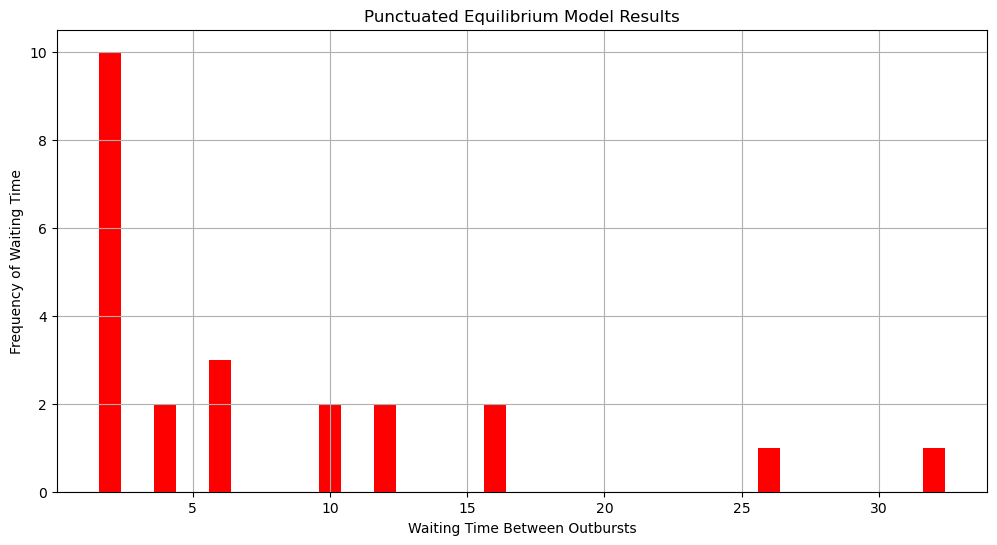

In [30]:
# figure5
import numpy as np
import matplotlib.pyplot as plt
model = EpsteinNetworkCivilViolence(
    width=40,
    height=40,
    citizen_density=0.7,
    cop_density=0.04,
    citizen_vision=2,
    cop_vision=2,
    legitimacy=0.8,
    max_jail_term=15,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=1000,
    alpha=0.1,
    jail_factor=1.1,
    impact_chance=0.5,
    legitimacy_impact=0.01,
    incitation_threshold=10
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# Assume model has been run and waiting_times have been collected as follows:
waiting_times = model.waiting_times

# Convert list to numpy array for easier manipulation
waiting_times_array = np.array(waiting_times)

# Get unique waiting times and their counts
unique_times, counts = np.unique(waiting_times_array, return_counts=True)

# Plotting the frequencies against the waiting times
plt.figure(figsize=(12, 6))
plt.bar(unique_times, counts, color='red')
plt.xlabel('Waiting Time Between Outbursts')
plt.ylabel('Frequency of Waiting Time')
plt.title('Punctuated Equilibrium Model Results')
plt.grid(True)
plt.show()

Active Count: 201
Active Count: 186
Active Count: 152
Active Count: 145
Active Count: 141
Active Count: 127
Active Count: 106
Active Count: 109
Active Count: 102
Active Count: 100
Active Count: 90
Outburst ends at step 21
Active Count: 94
Active Count: 91
Active Count: 91
Active Count: 88
Active Count: 100
Outburst starts, wait time recorded: 10
Active Count: 107
Active Count: 103
Active Count: 94
Outburst ends at step 37
Active Count: 80
Active Count: 81
Active Count: 68
Active Count: 85
Active Count: 97
Active Count: 83
Active Count: 72
Active Count: 68
Active Count: 63
Active Count: 75
Active Count: 74
Active Count: 75
Active Count: 80
Active Count: 91
Active Count: 98
Active Count: 91
Active Count: 84
Active Count: 91
Active Count: 98
Active Count: 84
Active Count: 97
Active Count: 76
Active Count: 75
Active Count: 76
Active Count: 82
Active Count: 96
Active Count: 103
Outburst starts, wait time recorded: 54
Active Count: 97
Outburst ends at step 93
Active Count: 82
Active Count: 8

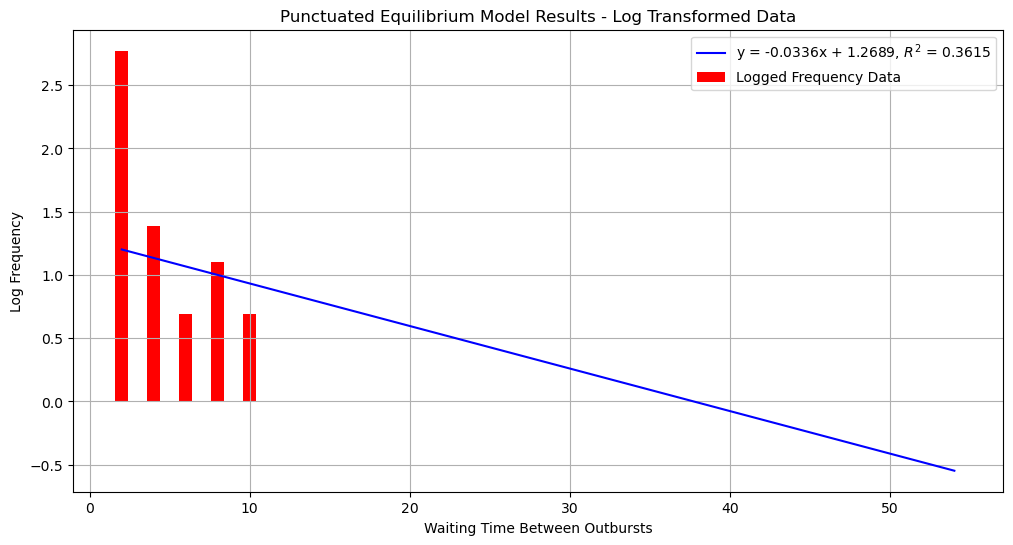

In [17]:
# figure6
from sklearn.linear_model import LinearRegression

# Assuming the simulation model has already been run, and waiting_times have been collected
simulation_model = EpsteinNetworkCivilViolence(
    width=40,
    height=40,
    citizen_density=0.7,
    cop_density=0.04,
    citizen_vision=2,
    cop_vision=2,
    legitimacy=0.8,
    max_jail_term=15,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=1000,
    alpha=0.1,
    jail_factor=1.1,
    impact_chance=0.5,
    legitimacy_impact=0.01,
    incitation_threshold=10
)

for _ in range(1000):
    simulation_model.step()

waiting_times = simulation_model.waiting_times

# Convert the list to a numpy array for easier manipulation
waiting_times_array = np.array(waiting_times)

# Obtain unique waiting times and their counts
unique_times, counts = np.unique(waiting_times_array, return_counts=True)

# Log-transform the counts to prepare for regression analysis
log_freq = np.log(counts)

# Prepare data for linear regression
X = unique_times.reshape(-1, 1)
y = log_freq.reshape(-1, 1)

# Perform linear regression
regression_model = LinearRegression()
regression_model.fit(X, y)

# Get the regression line for plotting
line = regression_model.predict(X)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(unique_times, log_freq, color='red', label='Logged Frequency Data')
plt.plot(unique_times, line, color='blue', label=f'y = {regression_model.coef_[0][0]:.4f}x + {regression_model.intercept_[0]:.4f}, $R^2$ = {regression_model.score(X, y):.4f}')
plt.xlabel('Waiting Time Between Outbursts')
plt.ylabel('Log Frequency')
plt.title('Punctuated Equilibrium Model Results - Log Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

Active Count: 237
Active Count: 194
Active Count: 173
Active Count: 147
Active Count: 149
Active Count: 111
Active Count: 98
Outburst ends at step 13
Active Count: 99
Active Count: 104
Outburst starts, wait time recorded: 4
Active Count: 101
Active Count: 95
Outburst ends at step 21
Active Count: 99
Active Count: 98
Active Count: 99
Active Count: 102
Outburst starts, wait time recorded: 8
Active Count: 94
Outburst ends at step 31
Active Count: 95
Active Count: 91
Active Count: 84
Active Count: 72
Active Count: 86
Active Count: 94
Active Count: 104
Outburst starts, wait time recorded: 14
Active Count: 97
Outburst ends at step 47
Active Count: 91
Active Count: 77
Active Count: 84
Active Count: 103
Outburst starts, wait time recorded: 8
Active Count: 103
Active Count: 91
Outburst ends at step 59
Active Count: 96
Active Count: 91
Active Count: 77
Active Count: 82
Active Count: 82
Active Count: 93
Active Count: 88
Active Count: 80
Active Count: 91
Active Count: 100
Outburst starts, wait tim

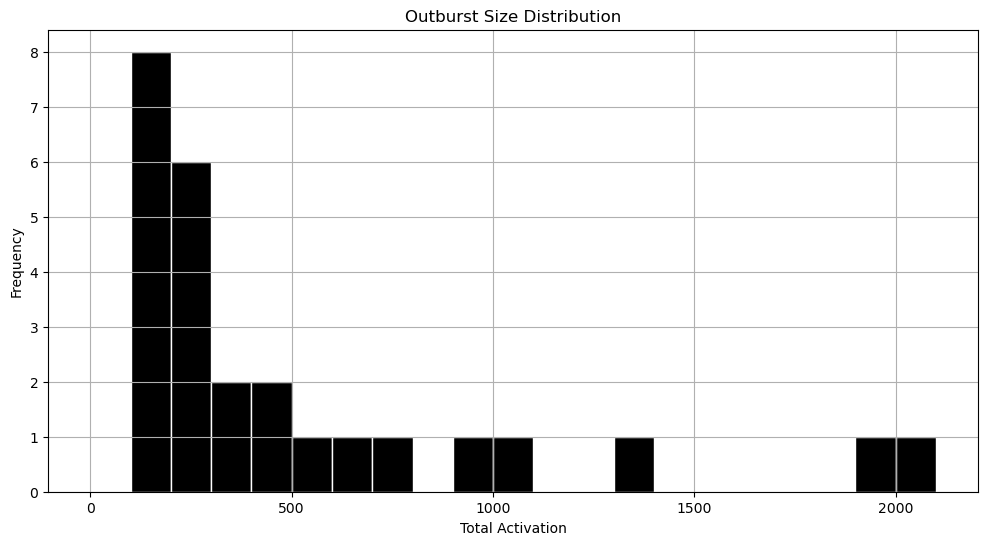

In [18]:
# figure7
model = EpsteinNetworkCivilViolence(
    width=40,
    height=40,
    citizen_density=0.7,
    cop_density=0.04,
    citizen_vision=2,
    cop_vision=2,
    legitimacy=0.8,
    max_jail_term=15,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=1000,
    alpha=0.1,
    jail_factor=1.1,
    impact_chance=0.5,
    legitimacy_impact=0.01,
    incitation_threshold=10
    
)

for _ in range(1000):
    model.step()

# Data for plotting
outburst_sizes = model.outburst_sizes

# Define the bins for the histogram
bins = range(0, max(outburst_sizes) + 100, 100)  # Adjust bin size and range as needed

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(outburst_sizes, bins=bins, color='black', edgecolor='white')
plt.xlabel('Total Activation')
plt.ylabel('Frequency')
plt.title('Outburst Size Distribution')
plt.grid(True)
plt.show()

Active Count: 181
Active Count: 195
Active Count: 146
Active Count: 105
Active Count: 103
Active Count: 71
Outburst ends at step 11
Active Count: 61
Active Count: 62
Active Count: 57
Active Count: 49
Active Count: 56
Active Count: 50
Active Count: 51
Active Count: 44
Active Count: 53
Active Count: 53
Active Count: 52
Active Count: 49
Active Count: 58
Active Count: 62
Active Count: 53
Active Count: 43
Active Count: 54
Active Count: 47
Active Count: 52
Active Count: 49
Active Count: 43
Active Count: 49
Active Count: 52
Active Count: 49
Active Count: 57
Active Count: 63
Active Count: 64
Active Count: 43
Active Count: 60
Active Count: 48
Active Count: 60
Active Count: 61
Active Count: 36
Active Count: 34
Active Count: 49
Active Count: 55
Active Count: 42
Active Count: 44
Active Count: 55
Active Count: 51
Active Count: 53
Active Count: 45
Active Count: 46
Active Count: 41
Active Count: 50
Active Count: 46
Active Count: 51
Active Count: 61
Active Count: 63
Active Count: 54
Active Count: 52
A

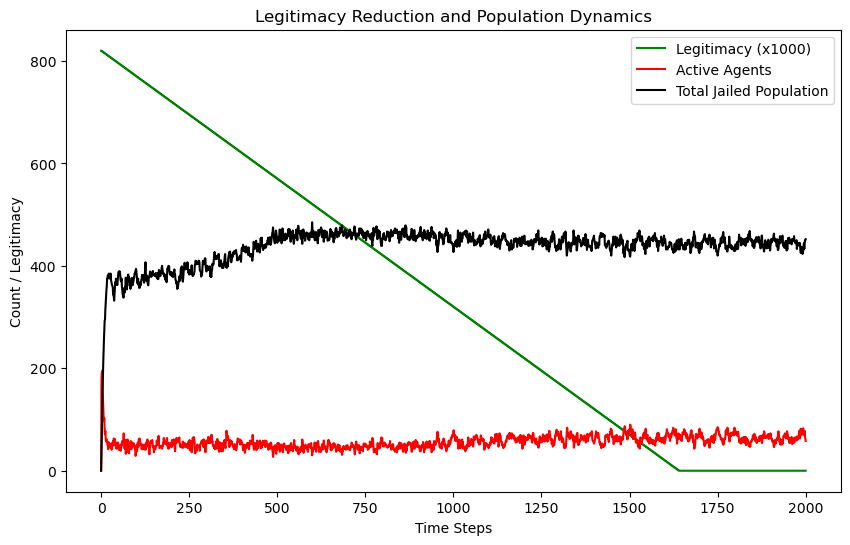

In [19]:
# Figure9&10
model = EpsteinNetworkCivilViolence(
    width=40, height=40, citizen_density=0.7, cop_density=0.04,
    citizen_vision=2, cop_vision=2, legitimacy=0.82, max_jail_term=30,
    active_threshold=0.1, arrest_prob_constant=2.3, movement=True, max_iters=1000, legitimacy_mode='gradual', cop_density_mode='constant',alpha=0.1,
    jail_factor=1.1, impact_chance=0.5, legitimacy_impact=0.01, incitation_threshold=10
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# plot
plt.figure(figsize=(10, 6))
plt.plot(data['Legitimacy']*1000, label='Legitimacy (x1000)', color='green')
plt.plot(data['Active'], label='Active Agents', color='red')
plt.plot(data['Jailed'], label='Total Jailed Population', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Count / Legitimacy')
plt.title('Legitimacy Reduction and Population Dynamics')
plt.legend()
plt.show()

Active Count: 403
Active Count: 369
Active Count: 337
Active Count: 290
Active Count: 271
Active Count: 221
Active Count: 187
Active Count: 179
Active Count: 161
Active Count: 170
Active Count: 168
Active Count: 179
Active Count: 169
Active Count: 167
Active Count: 165
Active Count: 162
Active Count: 170
Active Count: 165
Active Count: 165
Active Count: 169
Active Count: 174
Active Count: 183
Active Count: 170
Active Count: 174
Active Count: 162
Active Count: 180
Active Count: 152
Active Count: 150
Active Count: 162
Active Count: 176
Active Count: 163
Active Count: 162
Active Count: 185
Active Count: 159
Active Count: 171
Active Count: 196
Active Count: 166
Active Count: 167
Active Count: 161
Active Count: 151
Active Count: 154
Active Count: 161
Active Count: 165
Active Count: 166
Active Count: 178
Active Count: 192
Active Count: 174
Active Count: 193
Active Count: 192
Active Count: 191
Active Count: 211
Active Count: 190
Active Count: 174
Active Count: 167
Active Count: 164
Active Cou

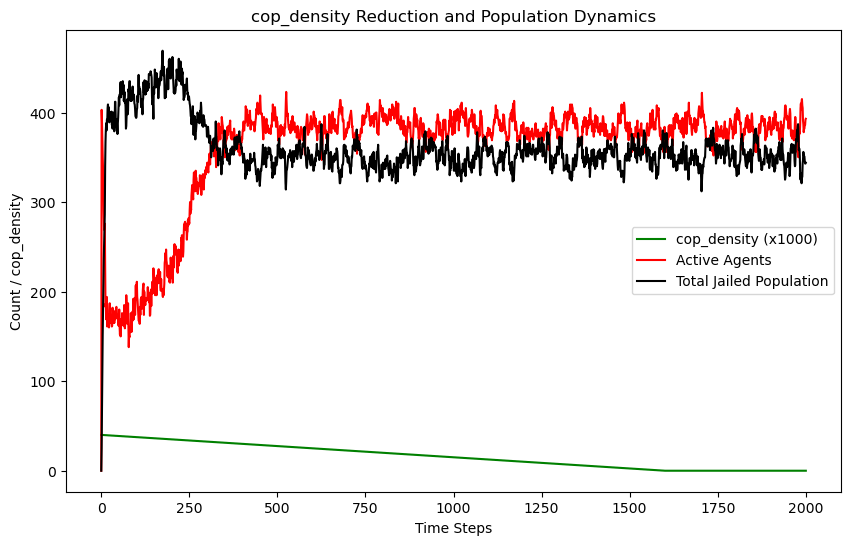

In [21]:
# Figure11
model = EpsteinNetworkCivilViolence(
    width=40, height=40, citizen_density=0.7, cop_density=0.04,
    citizen_vision=2, cop_vision=2, legitimacy=0.7, max_jail_term=15,
    active_threshold=0.1, arrest_prob_constant=2.3, movement=True, max_iters=1000, legitimacy_mode='constant', cop_density_mode='gradual', alpha=0.1,
    jail_factor=1.1, impact_chance=0.5, legitimacy_impact=0.01, incitation_threshold=10
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# plot
plt.figure(figsize=(10, 6))
plt.plot(data['Cop_Density']*1000, label='cop_density (x1000)', color='green')
plt.plot(data['Active'], label='Active Agents', color='red')
plt.plot(data['Jailed'], label='Total Jailed Population', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Count / cop_density')
plt.title('cop_density Reduction and Population Dynamics')
plt.legend()
plt.show()